<a href="https://colab.research.google.com/github/sherylla/UCB_Final_Project/blob/will_barnes/finproj_segment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''NOTE THAT THIS WAS MEANT TO BE RUN IN GOOGLE COLLAB - 
IF YOU WOULD LIKE A LINK TO THE NOTEBOOK IN GOOGLE COLLAB, IT IS PASTED BELOW
https://colab.research.google.com/drive/1z7OY51sPc1xl17AQ999G01sGf8PKrBr_?usp=sharing'''

'NOTE THAT THIS WAS MEANT TO BE RUN IN GOOGLE COLLAB - \nIF YOU WOULD LIKE A LINK TO THE NOTEBOOK IN GOOGLE COLLAB, IT IS PASTED BELOW\nhttps://colab.research.google.com/drive/1z7OY51sPc1xl17AQ999G01sGf8PKrBr_?usp=sharing'

In [0]:




import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler



In [4]:
'DATA LOADING'

#Using PySpark
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()
# Read in data from S3 Buckets
from pyspark import SparkFiles
url_red ="https://sheryllagp-bucket.s3-us-west-2.amazonaws.com/winequality-red.csv"
spark.sparkContext.addFile(url_red)
spark_raw_red = spark.read.csv(SparkFiles.get("winequality-red.csv"), sep=",", header=True, inferSchema=True)


--2020-06-08 20:54:28--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.69MB/s    in 0.2s    

2020-06-08 20:54:29 (4.69 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [5]:
spark_raw_red.show()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [7]:
spark_url_white ="https://sheryllagp-bucket.s3-us-west-2.amazonaws.com/winequality-white.csv"
spark.sparkContext.addFile(spark_url_white)
spark_raw_white = spark.read.csv(SparkFiles.get("winequality-white.csv"), sep=",", header=True, inferSchema=True)
# Show DataFrame
spark_raw_white.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

In [0]:
df_raw_red = spark_raw_red.select("*").toPandas()


In [0]:
 df_raw_white = spark_raw_white.select("*").toPandas()


In [10]:
'DATA CLEANING'
#check length of raw red
len(df_raw_red)

1599

In [11]:
#check length of raw white
len(df_raw_white)

4898

In [12]:
#add a wine type of red: 0
df_raw_red['type']=0
df_raw_red.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0


In [13]:
#add a wine type of white: 1
df_raw_white['type']=1
df_raw_white.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,1


In [0]:
#combine the dataframes, white and red together
df_combo_raw = df_raw_red.append(df_raw_white)

In [15]:
#sanity check it
df_combo_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [16]:
#check types of data - good, all numbers
df_combo_raw.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int32
type                      int64
dtype: object

In [17]:
#check for missing values
count_nan = len(df_combo_raw) - df_combo_raw.count()
print(count_nan)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


In [18]:
#check for number of quality targets - each wine has a quality score between 3 and 9
df_combo_raw.groupby(['quality']).count().head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
quality,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30
4,216,216,216,216,216,216,216,216,216,216,216,216
5,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138
6,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836
7,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079
8,193,193,193,193,193,193,193,193,193,193,193,193
9,5,5,5,5,5,5,5,5,5,5,5,5


In [19]:
# there are too many values for the target. I will change each target to be High Quality, a value of 1, or Low Quality, a value of 0. High quality sits between 7,8,9. Low Quality sits between 3,4,5,6
df_copy = df_combo_raw.copy()
df_copy.loc[(df_copy.quality < 7),'quality']=0
df_copy.loc[(df_copy.quality > 6),'quality']=1

df_copy.groupby(['quality']).count().head(20)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
quality,,,,,,,,,,,,
0,5220,5220,5220,5220,5220,5220,5220,5220,5220,5220,5220,5220
1,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277


In [0]:
#change the name of the DF for readability
df_combo_cleaned = df_copy        

In [21]:
#scale the data
data_scaler = StandardScaler()
df_combo_scaled = data_scaler.fit_transform(df_combo_cleaned.drop(columns="quality"))
df_combo_scaled

array([[ 0.14247327,  2.18883292, -2.19283252, ...,  0.19309677,
        -0.91546416, -1.75018984],
       [ 0.45103572,  3.28223494, -2.19283252, ...,  0.99957862,
        -0.58006813, -1.75018984],
       [ 0.45103572,  2.55330026, -1.91755268, ...,  0.79795816,
        -0.58006813, -1.75018984],
       ...,
       [-0.55179227, -0.6054167 , -0.88525328, ..., -0.47897144,
        -0.91546416,  0.57136659],
       [-1.32319841, -0.30169391, -0.12823371, ..., -1.016626  ,
         1.9354021 ,  0.57136659],
       [-0.93749534, -0.78765037,  0.42232597, ..., -1.41986693,
         1.09691202,  0.57136659]])

In [22]:
#check if data is scaled
import numpy as np
print(np.mean(df_combo_scaled[:,0]))
print(np.std(df_combo_scaled[:,0]))

-3.8496389562498884e-16
1.0


In [23]:
'MODEL CREATION'

'MODEL CREATION'

In [0]:
#define target and features
y = df_combo_cleaned["quality"]
X = df_combo_scaled

In [0]:
#train the data set
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)

In [119]:
Counter(y_train)


Counter({0: 3914, 1: 958})

Counter({0: 3914, 1: 3914})

In [104]:
'''BEGIN SEGMENT TWO: PCA'''
variance_list = [0.95,0.90,0.85,0.80,0.75,0.70]

from sklearn.decomposition import PCA

from sklearn import metrics

benchmark_cols = ['Variance retained','n_Components','Accuracy_percentage']
benchmark = pd.DataFrame(columns = benchmark_cols)

def benchmark_pca(variance,train_img,train_lbl,test_img,test_lbl):
    global benchmark
    print(train_img.shape)
    pca = PCA(variance)
    pca.fit(train_img)
    n_components = pca.n_components_
    train_img = pca.transform(train_img)

    # pca.fit(test_img)
    test_img = pca.transform(test_img)
    logisticRegr = LogisticRegression(solver = 'lbfgs')
    #start = time.time()
    logisticRegr.fit(train_img, train_lbl)
    #end =  time.time()
 
    #timing = end-start   

    # Predict for Multiple Observations (images) at Once
    predicted = logisticRegr.predict(test_img)   

    # generate evaluation metrics
    accuracy = (metrics.accuracy_score(test_lbl, predicted))
    #return 
    a = dict(zip(benchmark_cols,[variance,n_components,accuracy]))
    benchmark = benchmark.append(a,ignore_index=True)

for variance in variance_list:
    benchmark_pca(variance,X_train,y_train,X_test,y_test)

(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)


In [105]:
benchmark

,Variance retained,n_Components,Accuracy_percentage
0,0.95,9.0,0.817231
1,0.90,8.0,0.817231
2,0.85,6.0,0.820923
3,0.80,5.0,0.814154
4,0.75,5.0,0.814154
5,0.70,4.0,0.804308


Text(0.5, 1.0, 'no of components vs accuracy')

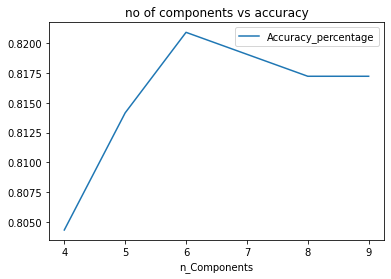

In [106]:
benchmark.plot(x=1,y=-1)
plt.title("no of components vs accuracy")

In [0]:
from sklearn.pipeline import Pipeline
pca = PCA(n_components=6)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

In [108]:
print(accuracy_score(y_test, predictions))

0.820923076923077


In [109]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[1257   49]
 [ 242   77]]


In [110]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1306
           1       0.61      0.24      0.35       319

    accuracy                           0.82      1625
   macro avg       0.72      0.60      0.62      1625
weighted avg       0.79      0.82      0.79      1625



In [0]:
'''NOTICING THAT THE MODEL IS NOT AS ACCURATE AT PREDICITING QUALITY WINE (1) AS IT IS POOR WINE (0), GOING TO TRY VARIOUS METHODS OF RESAMPLING BELOW. AS YOU WILL SEE, ALL MADE THE MODEL LESS ACCURATE AND ARE THUS NOT ADVISABLE.'''

In [111]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
pca = PCA(n_components=6)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
smote_predictions = pipe.predict(X_test)

In [113]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
print(accuracy_score(y_test, smote_predictions))

0.715076923076923


In [114]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:

#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE
pca = PCA(n_components=6)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
ros_predictions = pipe.predict(X_test)

In [117]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE

print(accuracy_score(y_test, ros_predictions))

0.7163076923076923


In [118]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE

report = classification_report(y_test, ros_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1306
           1       0.39      0.77      0.52       319

    accuracy                           0.72      1625
   macro avg       0.66      0.74      0.66      1625
weighted avg       0.82      0.72      0.74      1625



In [128]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 958, 1: 958})

In [0]:
#MODEL GETS LESS ACCURATE WITH RUS, DO NOT USE RESAMPLE

pca = PCA(n_components=6)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
rus_predictions = pipe.predict(X_test)

In [131]:
#MODEL GETS LESS ACCURATE WITH RUS, DO NOT USE RESAMPLE

print(accuracy_score(y_test, rus_predictions))

0.7101538461538461


In [132]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE


pca = PCA(n_components=6)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
cc_predictions = pipe.predict(X_test)

In [136]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE

print(accuracy_score(y_test, cc_predictions))

0.6916923076923077
